In [1]:
import numpy as np 
import yt 


# define the highest resolution grid 
highest_res = np.array((128,128,128), dtype=int)
grid_dims = np.array((32,32,32), dtype=int)

# virtual pyramid settings
refine_factor = np.array((2,2,2), dtype=int)

# spatial extent of the whole domain
domain_le = np.array([0., 0., 0.])
domain_re = np.array([1., 1., 1.])

In [2]:
# calculate max level : coarsen until we get 1 grid across domain
max_allowed=100
current_level_dims = highest_res 
current_grid_dims = grid_dims

for i_level in range(max_allowed):
    n_grids_i = current_level_dims / grid_dims
    print(n_grids_i)
    if np.any( n_grids_i< 1): 
        print("cannot coarsen further")
        max_level = i_level - 1 # yt levels are 0-indexed
        break 
    current_level_dims = current_level_dims // refine_factor    

max_level

[4. 4. 4.]
[2. 2. 2.]
[1. 1. 1.]
[0.5 0.5 0.5]
cannot coarsen further


2

In [3]:
def _single_level_grids(level, level_dims, grid_dims):

    # level : the current level number
    # level_dims : the resolution of the entire level 
    # grid_dims : the resoulton of a single grid (i.e., one chunk)
    

    n_grids_by_dim = level_dims // grid_dims  # number of grids in each dim 
    n_grids = int(np.prod(n_grids_by_dim)) # total grids at this level 
    
    # spatial extent of a grid in each dim :
    grid_ds = (domain_re - domain_le) / n_grids_by_dim 
    
    grids = [] 
    for i_grid in range(n_grids):
        ijk_grid = np.unravel_index(i_grid, n_grids_by_dim, order='F')
        # lei = ijk_grid * grid_dims  # global start index at this level
        # rei = lei + grid_dims       # global stop index at this level
        le = domain_le + ijk_grid * grid_ds 
        re = le + grid_ds
        grid_dict = {'left_edge': le, 
                     'right_edge': re, 
                     'dimensions': grid_dims, 
                     'level': level, 
                     }                     
        grids.append(grid_dict)
    return grids

grids = _single_level_grids(4, highest_res, grid_dims)
print(len(grids))
grids[:5]

64


[{'left_edge': array([0., 0., 0.]),
  'right_edge': array([0.25, 0.25, 0.25]),
  'dimensions': array([32, 32, 32]),
  'level': 4},
 {'left_edge': array([0.25, 0.  , 0.  ]),
  'right_edge': array([0.5 , 0.25, 0.25]),
  'dimensions': array([32, 32, 32]),
  'level': 4},
 {'left_edge': array([0.5, 0. , 0. ]),
  'right_edge': array([0.75, 0.25, 0.25]),
  'dimensions': array([32, 32, 32]),
  'level': 4},
 {'left_edge': array([0.75, 0.  , 0.  ]),
  'right_edge': array([1.  , 0.25, 0.25]),
  'dimensions': array([32, 32, 32]),
  'level': 4},
 {'left_edge': array([0.  , 0.25, 0.  ]),
  'right_edge': array([0.25, 0.5 , 0.25]),
  'dimensions': array([32, 32, 32]),
  'level': 4}]

In [4]:
grids = [] 

current_level_dims = highest_res 

for i_lev in range(max_level, -1,-1):    
    print(current_level_dims)        
    grids_i = _single_level_grids(i_lev, current_level_dims, grid_dims)
    grids.extend(grids_i)    
    current_level_dims = current_level_dims // refine_factor    

[128 128 128]
[64 64 64]
[32 32 32]


In [5]:
grids.reverse()  # probably not really needed. WAIT IT IS NEEDED

In [6]:
grids[0:6]

[{'left_edge': array([0., 0., 0.]),
  'right_edge': array([1., 1., 1.]),
  'dimensions': array([32, 32, 32]),
  'level': 0},
 {'left_edge': array([0.5, 0.5, 0.5]),
  'right_edge': array([1., 1., 1.]),
  'dimensions': array([32, 32, 32]),
  'level': 1},
 {'left_edge': array([0. , 0.5, 0.5]),
  'right_edge': array([0.5, 1. , 1. ]),
  'dimensions': array([32, 32, 32]),
  'level': 1},
 {'left_edge': array([0.5, 0. , 0.5]),
  'right_edge': array([1. , 0.5, 1. ]),
  'dimensions': array([32, 32, 32]),
  'level': 1},
 {'left_edge': array([0. , 0. , 0.5]),
  'right_edge': array([0.5, 0.5, 1. ]),
  'dimensions': array([32, 32, 32]),
  'level': 1},
 {'left_edge': array([0.5, 0.5, 0. ]),
  'right_edge': array([1. , 1. , 0.5]),
  'dimensions': array([32, 32, 32]),
  'level': 1}]

In [7]:
# fill in data for every level? maybe not needed
for g in grids:
    # if g['level'] == max_level:
    g["gas", "density"] = (
     0.1 * np.random.random(g["dimensions"]) + g["level"],
     "g/cm**3",
    )

In [8]:
ds = yt.load_amr_grids(grids, grid_dims)

yt : [INFO     ] 2024-08-30 14:56:26,274 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-08-30 14:56:26,275 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-08-30 14:56:26,275 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-30 14:56:26,275 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-30 14:56:26,276 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-08-30 14:56:26,348 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,348 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,349 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,349 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,352 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



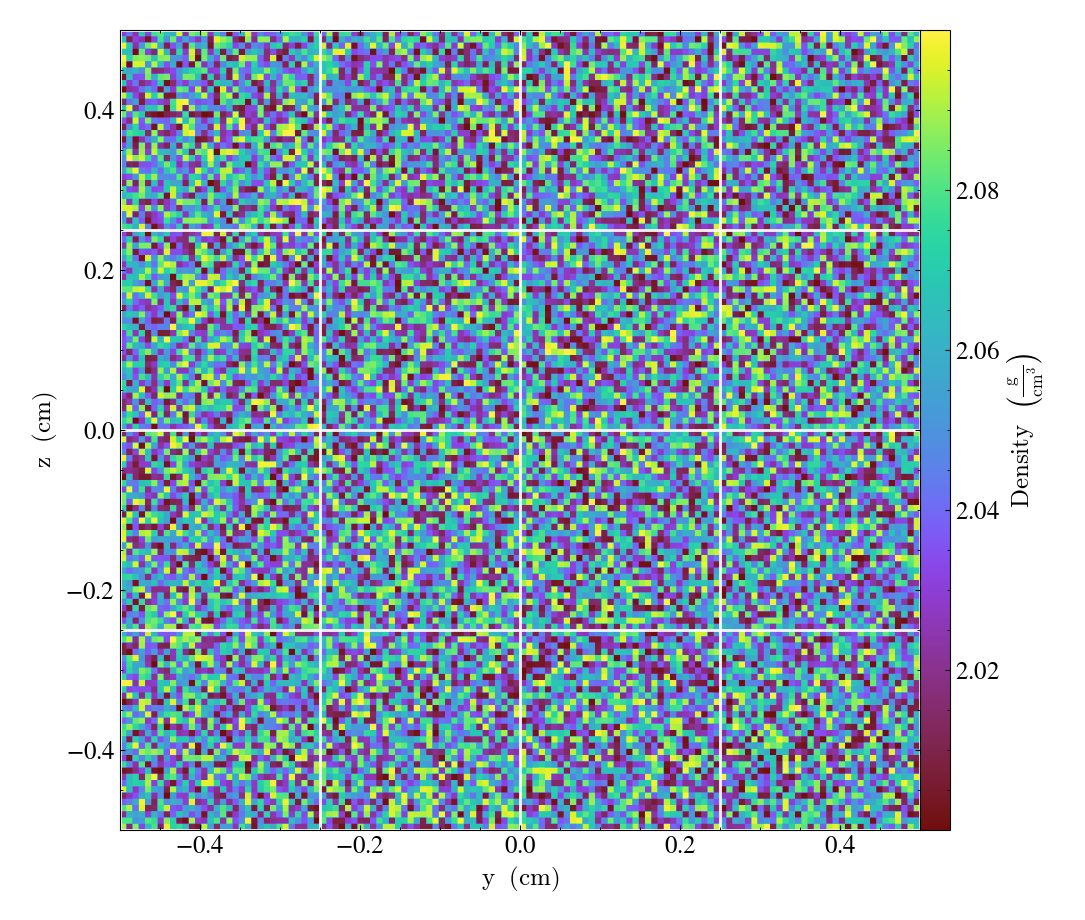

In [9]:
slc = yt.SlicePlot(ds, 'x', ('gas', 'density'))
slc.set_log(('gas', 'density'), False)
slc.annotate_grids(edgecolors=(1,1,1),linewidth=2)

yt : [INFO     ] 2024-08-30 14:56:26,789 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,789 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,790 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,790 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-08-30 14:56:26,791 Making a fixed resolution buffer of (('gas', 'density')) 200 by 200



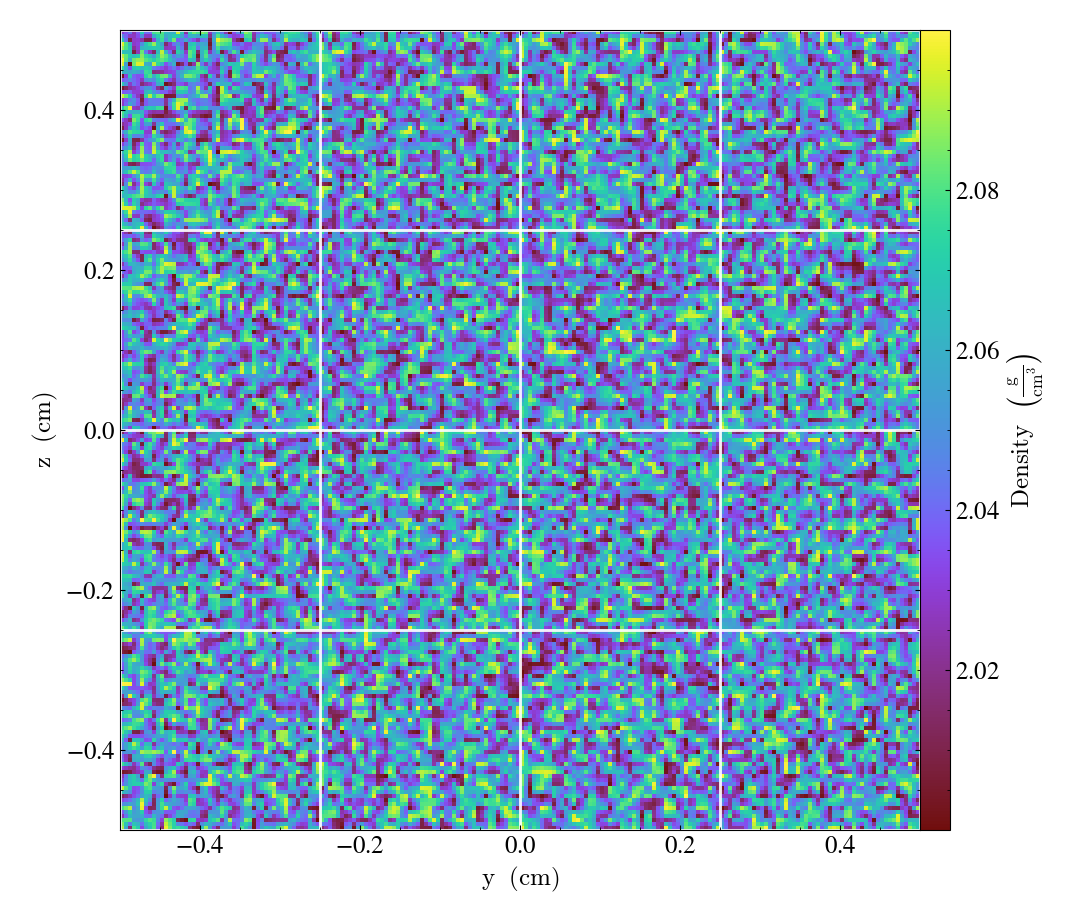

In [10]:
slc = yt.SlicePlot(ds, 'x', ('gas', 'density'), buff_size=(200,200))
slc.set_log(('gas', 'density'), False)
slc.annotate_grids(edgecolors=(1,1,1),linewidth=2)